# Stock Price Prediction (NIFTY 50)

Link : https://www.kaggle.com/datasets/ashishjangra27/nifty-50-25-yrs-data

LinkedIn: https://www.linkedin.com/in/ashish-jangra

This project focuses on predicting **NIFTY 50 stock prices** using both **Machine Learning (ML)** and **Deep Learning (DL)** approaches.  
The workflow involves preparing time-series data, training multiple models, and comparing their performance.

---

## Pipeline Overview

1. **Data Loading**
   - Load stock price data (`data.csv`).
   - Features: `Open`, `Close`, `High`, `Low`.

2. **Data Preparation**
   - Create supervised learning datasets using sliding windows (30–250 days).
   - Generate `(X, y)` pairs for each feature.

3. **Modeling**
   - **Machine Learning Models**  
     - Linear: `LinearRegression`, `Ridge`, `Lasso`  
     - Tree-based: `RandomForest`, `GradientBoosting`, `XGBoost`, `LightGBM`  
     - Others: `SVR`, `KNN`
   - **Deep Learning Models**  
     - RNN, LSTM, GRU, Bidirectional LSTM (Keras Sequential API)

4. **Training**
   - Train models on rolling window datasets.
   - Evaluate using **MAE** and **RMSE**.

5. **Evaluation & Comparison**
   - Store results for all models.
   - Compare ML vs DL models for different input window sizes.

---

## Key Highlights
- Hybrid pipeline combining **classical ML** and **neural networks**.  
- Uses **multiple time horizons (30–250 days)** for robust prediction.  
- Tracks **training and testing errors** to evaluate generalization.  

### 1. Import Libraries & Dataset

1. **Import Libraries**
   - `numpy`, `pandas`: data handling  
   - `tqdm`: progress bars  
   - `sklearn`: machine learning models & metrics  
   - `xgboost`, `lightgbm`: gradient boosting models  
   - `warnings`: ignore warnings  

2. **Load Dataset**
   - `df = pd.read_csv('data.csv')` → load data from CSV  
   - `df.head()` → preview first 5 rows  

3. **Models Imported**
   - Linear: `LinearRegression`, `Ridge`, `Lasso`  
   - Tree-based: `RandomForestRegressor`, `GradientBoostingRegressor`  
   - Others: `SVR`, `KNeighborsRegressor`, `XGBRegressor`, `LGBMRegressor`  

4. **Metrics Imported**
   - `mean_absolute_error`, `mean_squared_error` → to evaluate model performance  


In [23]:
import zipfile

with zipfile.ZipFile('/content/archive (1).zip', 'r') as zip_ref:
    zip_ref.extractall('data.csv')


In [24]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from copy import deepcopy


from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('data.csv/data.csv')
df.head()

,Date,Open,High,Low,Close
0,2000-01-03,1482.15,1592.90,1482.15,1592.2
1,2000-01-04,1594.40,1641.95,1594.40,1638.7
2,2000-01-05,1634.55,1635.50,1555.05,1595.8
3,2000-01-06,1595.80,1639.00,1595.80,1617.6
4,2000-01-07,1616.60,1628.25,1597.20,1613.3


### 2. Data Preparation

1. **Train-Test Split**
   - `train_test_split()` → split data into training & testing sets.  

2. **Models List**
   - A collection of regressors:  
     - Linear: `LinearRegression`, `Ridge`, `Lasso`  
     - Tree-based: `RandomForestRegressor`, `GradientBoostingRegressor`  
     - Others: `SVR`, `KNeighborsRegressor`, `XGBRegressor`, `LGBMRegressor`  

3. **Training Loop**
   - For each model:  
     - `fit()` → train on training data  
     - `predict()` → generate predictions on test data  

4. **Evaluation**
   - Metrics used:  
     - `mean_absolute_error`  
     - `mean_squared_error`  
   - Store results for comparison of all models.  

In [25]:
def return_pairs(column, days):
    pricess = list(column)
    X = []
    y = []
    for i in range(len(pricess) - days):
        X.append(pricess[i:i+days])
        y.append(pricess[i+days])
    return np.array(X), np.array(y)

target_columns =  ['Open', 'Close', 'High', 'Low']
day_chunks =  [30, 45, 60, 90, 120, 150 ,200, 250]

chunked_data = {}

for col in target_columns:
    for days in day_chunks:
        key_X = f"X_{col}_{days}"
        key_y = f"y_{col}_{days}"
        X, y = return_pairs(df[col], days)
        chunked_data[key_X] = X
        chunked_data[key_y] = y


chunk_pairs = []

for key in chunked_data.keys():
    if key.startswith("X_"):
        y_key = key.replace("X_", "y_")
        if y_key in chunked_data:
            chunk_pairs.append([key, y_key])

### 3. Define Neural Network Models

1. **Imports**
   - `Sequential` → build models layer-by-layer  
   - Layers: `Dense`, `SimpleRNN`, `LSTM`, `GRU`, `Bidirectional`  

2. **Model Builder Functions**
   - `build_rnn(input_shape)`  
     - Simple RNN with 50 units → `Dense(1)` output  
   - `build_lstm(input_shape)`  
     - LSTM with 50 units → `Dense(1)` output  
   - `build_gru(input_shape)`  
     - GRU with 50 units → `Dense(1)` output  
   - `build_bilstm(input_shape)`  
     - Bidirectional LSTM with 50 units → `Dense(1)` output  

3. **Compilation**
   - Optimizer: `adam`  
   - Loss: `mse` (Mean Squared Error)  

4. **Purpose**
   - All models → designed for **regression tasks on sequential data**.  

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional


def build_rnn(input_shape):
    model = Sequential([
        SimpleRNN(50, activation='tanh', input_shape=input_shape),
        Dense(1)   # regression output
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm(input_shape):
    model = Sequential([
        LSTM(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape):
    model = Sequential([
        GRU(50, activation='tanh', input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_bilstm(input_shape):
    model = Sequential([
        Bidirectional(LSTM(50, activation='tanh'), input_shape=input_shape),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

### 4. Define ML Models

1. **ml_models (Traditional ML)**
   - A list of tuples: (name, model instance)  
   - Includes:  
     - Linear models → `LinearRegression`, `Ridge`, `Lasso`  
     - Tree-based → `RandomForest`, `GradientBoosting`  
     - Others → `SVR`, `KNN`, `XGBoost`, `LightGBM`  

2. **dl_models (Deep Learning)**
   - A dictionary: {name: builder function}  
   - Includes:  
     - `"RNN"` → `build_rnn`  
     - `"LSTM"` → `build_lstm`  
     - `"GRU"` → `build_gru`  
     - `"Bidirectional_LSTM"` → `build_bilstm`  

3. **Purpose**
   - `ml_models`: ready-to-train classical ML regressors  
   - `dl_models`: functions that return compiled neural nets (when given `input_shape`)  

In [27]:
ml_models = [
    ("LinearRegression", LinearRegression()),
    ("Ridge", Ridge()),
    ("Lasso", Lasso()),
    ("RandomForest", RandomForestRegressor()),
    ("GradientBoosting", GradientBoostingRegressor()),
    ("SVR", SVR()),
    ("KNN", KNeighborsRegressor()),
    ("XGBoost", XGBRegressor(verbosity=0)),
    ("LightGBM", LGBMRegressor(verbosity=0))
]

dl_models = {
    "RNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "Bidirectional_LSTM": build_bilstm
}

### 5. Model Training

1. **Initialize**
   - `trained_models = {}` → store results of all models  

2. **Iterate over Data Pairs**
   - For each `(X, y)` in `chunk_pairs`  
   - Extract features `X_data` and target `y_data` from `chunked_data`  
   - Split → `train_test_split` (90% train, 10% test)  

3. **Train ML Models**
   - Loop through `ml_models`  
   - Use `deepcopy` to avoid reusing fitted models  
   - `fit()` on training data  
   - Predict on train & test sets  
   - Save model + metrics:  
     - `train_mae`, `train_rmse`  
     - `test_mae`, `test_rmse`  

4. **Prepare Data for DL**
   - Expand dims → shape becomes `(samples, timesteps, features)`  

5. **Train DL Models**
   - Loop through `dl_models`  
   - Build model with correct input shape  
   - Train for 10 epochs, batch size = 8  
   - Predict on train & test  
   - Save model + metrics (same as ML)  

6. **Final Output**
   - `trained_models` → dictionary with all trained models & evaluation scores  


In [28]:
trained_models = {}

# Define the specific target column, day chunks, and models for the assignment
target_column = 'High'
day_chunks = [30, 60, 90]
ml_models = [("KNN", KNeighborsRegressor())]
dl_models = {
    "RNN": build_rnn,
    "LSTM": build_lstm,
    "GRU": build_gru,
    "Bidirectional_LSTM": build_bilstm
}
epochs = 50

# Filter chunk_pairs for the assignment
chunk_pairs = [
    [X, y] for X, y in chunk_pairs
    if X.startswith(f"X_{target_column}_") and int(X.split('_')[-1]) in day_chunks
]

from sklearn.neighbors import KNeighborsRegressor

for X, y in tqdm(chunk_pairs):
    X_data = chunked_data[X]
    y_data = chunked_data[y]

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.1, random_state=42
    )

    # ML models
    for model_name, model in tqdm(ml_models):
        key = model_name + '_' + X[2:]
        model_copy = deepcopy(model)
        model_copy.fit(X_train, y_train)

        y_train_pred = model_copy.predict(X_train)
        y_test_pred = model_copy.predict(X_test)

        trained_models[key] = {
            'model': model_copy,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

    # DL models
    X_train_rnn = np.expand_dims(X_train, -1)
    X_test_rnn = np.expand_dims(X_test, -1)

    for model_name, builder in tqdm(dl_models.items()):
        key = model_name + '_' + X[2:]
        model_dl = builder((X_train.shape[1], 1))

        model_dl.fit(X_train_rnn, y_train, epochs=epochs, batch_size=8, verbose=0)

        y_train_pred = model_dl.predict(X_train_rnn).flatten()
        y_test_pred = model_dl.predict(X_test_rnn).flatten()

        trained_models[key] = {
            'model': model_dl,
            'train_mae': mean_absolute_error(y_train, y_train_pred),
            'train_rmse': np.sqrt(mean_squared_error(y_train, y_train_pred)),
            'test_mae': mean_absolute_error(y_test, y_test_pred),
            'test_rmse': np.sqrt(mean_squared_error(y_test, y_test_pred))
        }

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
177/177 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
176/176 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


### 6. Saving Model Statistics

1. **Collect Results**
   - Convert `trained_models` dict → list of dicts  
   - Each row = {"Model": model_name, metrics...}  

2. **Create DataFrame**
   - `results_df = pd.DataFrame([...])`  
   - Columns: `Model`, `train_mae`, `train_rmse`, `test_mae`, `test_rmse`  

3. **Sort Results**
   - Sort by `test_mae` (ascending → best first)  

4. **Display**
   - Show top 50 models with lowest test MAE  

In [29]:
results_df = pd.DataFrame([
    {"Model": name, **metrics}
    for name, metrics in trained_models.items()])

results_df.sort_values(by = 'test_mae', ascending = True).head(50)

,Model,model,train_mae,train_rmse,test_mae,test_rmse
10,KNN_High_90,KNeighborsRegressor(),36.929140,58.769966,48.790144,74.204848
5,KNN_High_60,KNeighborsRegressor(),36.850899,58.333589,52.819089,82.674612
0,KNN_High_30,KNeighborsRegressor(),42.646429,68.669169,56.933037,89.679421
1,RNN_High_30,"<Sequential name=sequential_8, built=True>",6388.505879,8842.455498,5891.350120,8445.985028
6,RNN_High_60,"<Sequential name=sequential_12, built=True>",6419.611942,8878.609195,5964.146109,8381.172572
11,RNN_High_90,"<Sequential name=sequential_16, built=True>",6435.829729,8883.818140,6158.243354,8600.814527
3,GRU_High_30,"<Sequential name=sequential_10, built=True>",6781.043285,9222.028698,6264.423859,8811.549063
4,Bidirectional_LSTM_High_30,"<Sequential name=sequential_11, built=True>",6906.776630,9328.009337,6388.209137,8914.029954
9,Bidirectional_LSTM_High_60,"<Sequential name=sequential_15, built=True>",6996.963118,9408.810935,6515.614771,8901.459546
8,GRU_High_60,"<Sequential name=sequential_14, built=True>",7024.837782,9429.844769,6543.480890,8922.164272


### 7. Top 50 Models

1. **Select Top 50**
   - Sort `results_df` by `test_mae`  
   - Keep best 50 models  

2. **Create Figure**
   - `plt.figure(figsize=(25, 8))` → wide chart for readability  

3. **Plot Lines**
   - Plot `train_mae` with markers  
   - Plot `test_mae` with markers  

4. **Customize**
   - Rotate x-axis labels (75°) for clarity  
   - Add labels (x, y), title, legend, and grid  
   - `tight_layout()` → avoid overlap  

5. **Show Chart**
   - `plt.show()` → display line chart comparing Train vs Test MAE

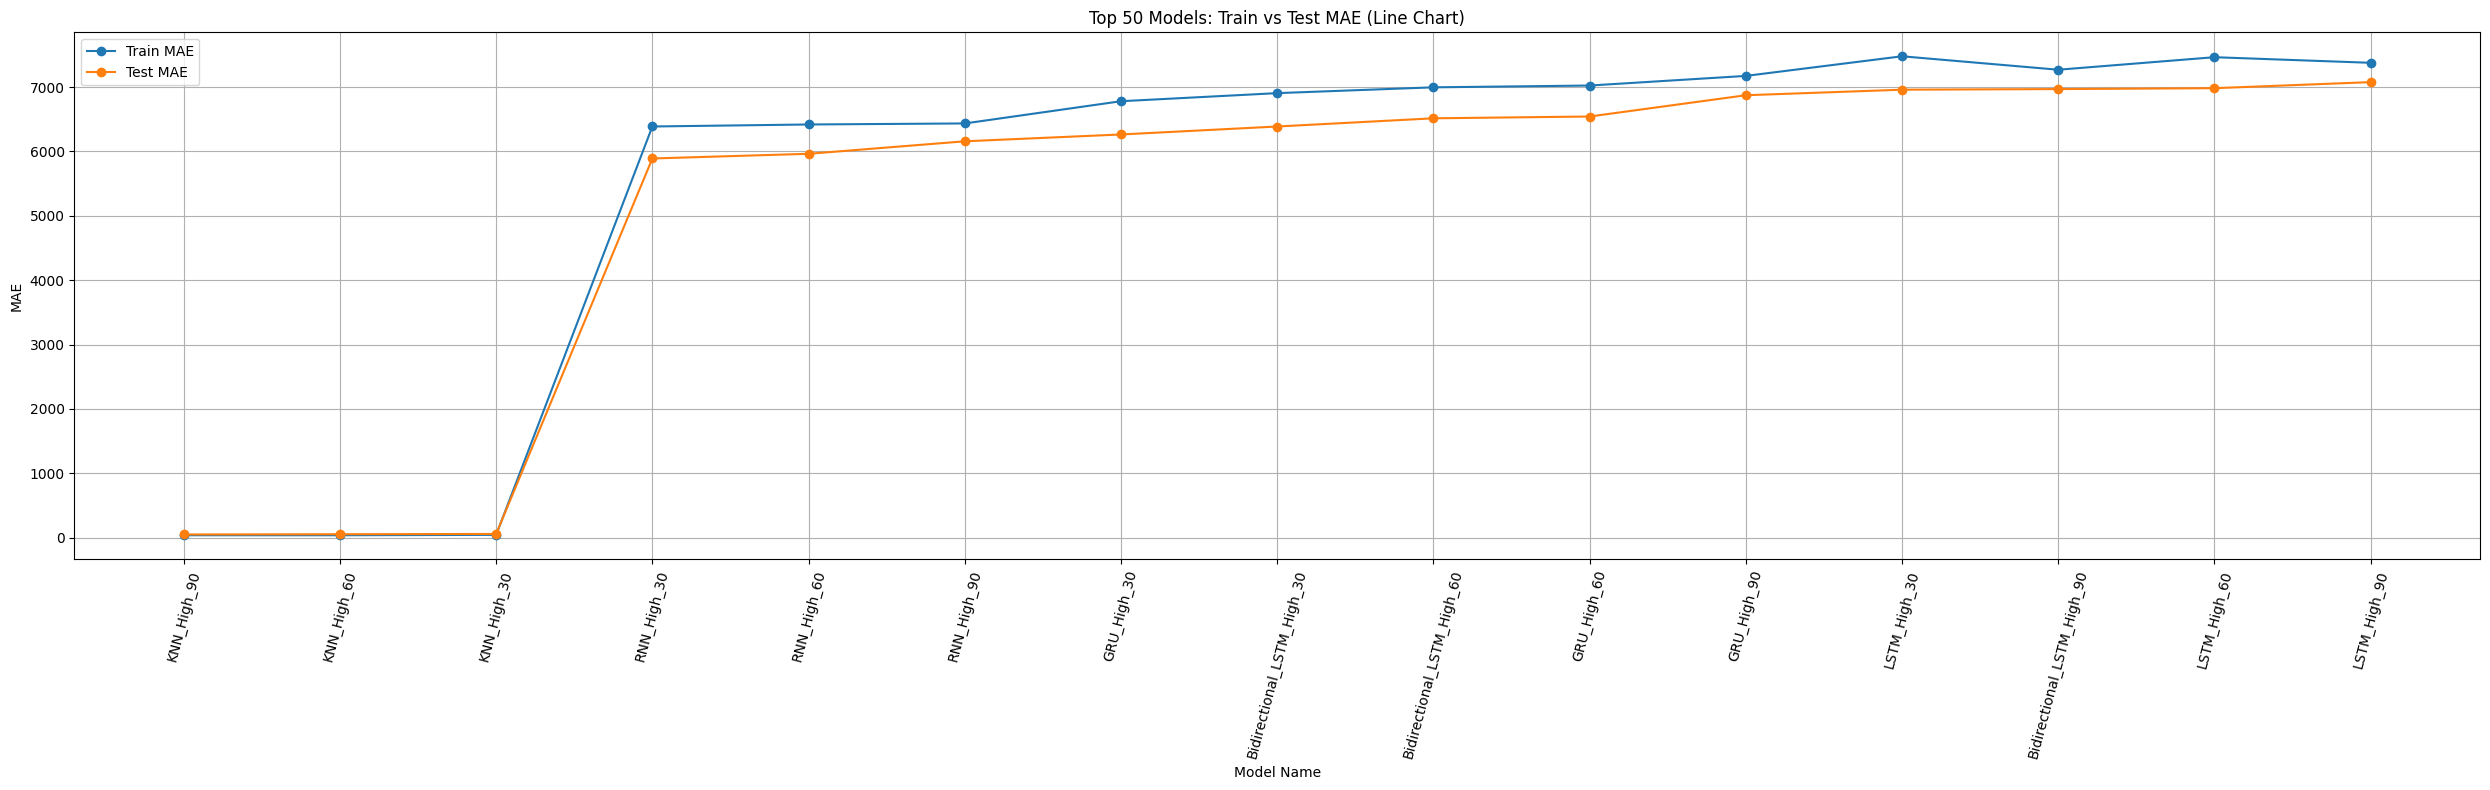

In [30]:
import matplotlib.pyplot as plt


top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)

plt.figure(figsize=(25, 8))
plt.plot(top_50['Model'], top_50['train_mae'], marker='o', label='Train MAE')

plt.plot(top_50['Model'], top_50['test_mae'], marker='o', label='Test MAE')

plt.xticks(rotation=75)
plt.xlabel('Model Name')
plt.ylabel('MAE')
plt.title('Top 50 Models: Train vs Test MAE (Line Chart)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 8. Relation btw. No of Input Days and Model Performance

1. **Extract Time Windows**
   - From each model name in `top_50`  
   - Split string by `_` → take last part (time window)  

2. **Count Frequencies**
   - `value_counts()` → count models per time window  
   - Sort by count (descending)  

3. **Plot Bar Chart**
   - X-axis: time windows  
   - Y-axis: number of models in Top 50  

4. **Customize**
   - Add labels (x, y), title  
   - Grid only on Y-axis for readability  
   - `tight_layout()` → clean layout  

5. **Show Chart**
   - `plt.show()` → display bar chart of time-window frequencies  

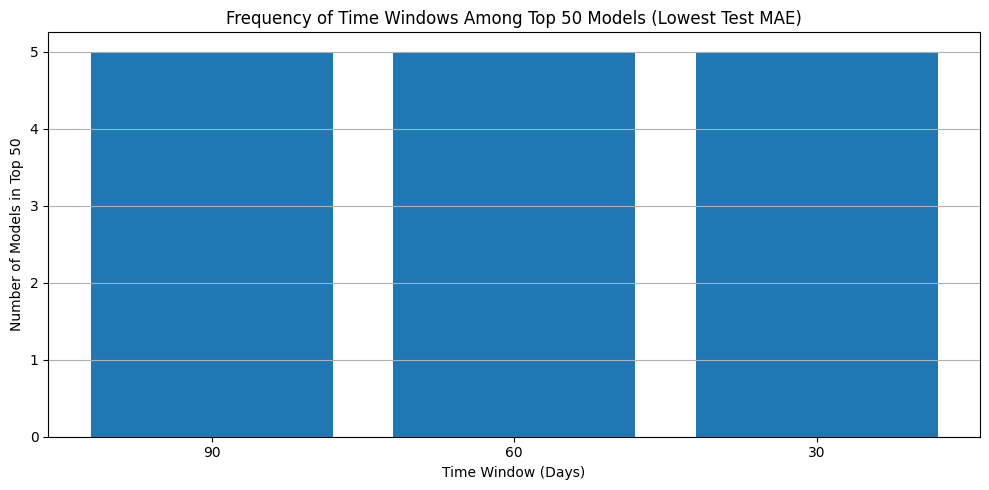

In [31]:
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
time_windows = pd.Series([i.split('_')[-1] for i in top_50['Model']])
time_counts = time_windows.value_counts().sort_values(ascending=False)  # Sort by count

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(time_counts.index, time_counts.values)

# Labels and aesthetics
plt.xlabel('Time Window (Days)')
plt.ylabel('Number of Models in Top 50')
plt.title('Frequency of Time Windows Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [42]:
time_windows = pd.Series([i.split('_')[-1] for i in results_df['Model']])
time_counts = time_windows.value_counts().sort_values(ascending=False)
print(time_counts)

30    5
60    5
90    5
Name: count, dtype: int64


### 9. Which column(HIGH/LOW/CLOSE/OPEN) should be taken into considration for model building?

1. **Select Top 50 Models**
   - Sort by `test_mae` → best 50 models  

2. **Extract Target Column**
   - From model names → split by `_`  
   - Take second last part as target column name  

3. **Count Frequencies**
   - `value_counts()` → count occurrences of each target  
   - Sort by frequency (descending)  

4. **Plot Bar Chart**
   - X-axis: target column names  
   - Y-axis: number of models in Top 50  

5. **Customize**
   - Add labels, title  
   - Grid on Y-axis for readability  
   - Use `tight_layout()` to prevent label overlap  

6. **Show Chart**
   - `plt.show()` → display bar chart of target column frequencies

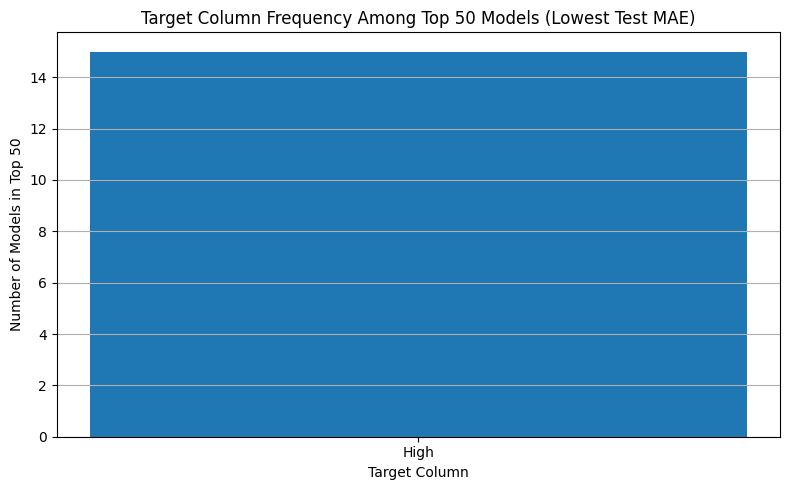

In [32]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract target columns from top 50 models
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
target_columns = pd.Series([i.split('_')[-2] for i in top_50['Model']])
target_counts = target_columns.value_counts().sort_values(ascending=False)  # Sort by count

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(target_counts.index, target_counts.values)

# Labels and aesthetics
plt.xlabel('Target Column')
plt.ylabel('Number of Models in Top 50')
plt.title('Target Column Frequency Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [40]:
print(target_columns.unique())

['High']


### 10. Which model works in general better on this task?

1. **Select Top 50 Models**
   - Sort `results_df` by `test_mae`  
   - Keep best 50 models  

2. **Extract Model Types**
   - From model names → split by `_`  
   - Take the first part as model type (e.g., LinearRegression, LSTM)  

3. **Count Frequencies**
   - `value_counts()` → count occurrences of each model type  
   - Sort counts in descending order  

4. **Plot Bar Chart**
   - X-axis: model types  
   - Y-axis: number of models in Top 50  

5. **Customize**
   - Add axis labels, title  
   - Grid only on Y-axis  
   - `tight_layout()` for spacing  

6. **Show Chart**
   - `plt.show()` → display bar chart of model type distribution  

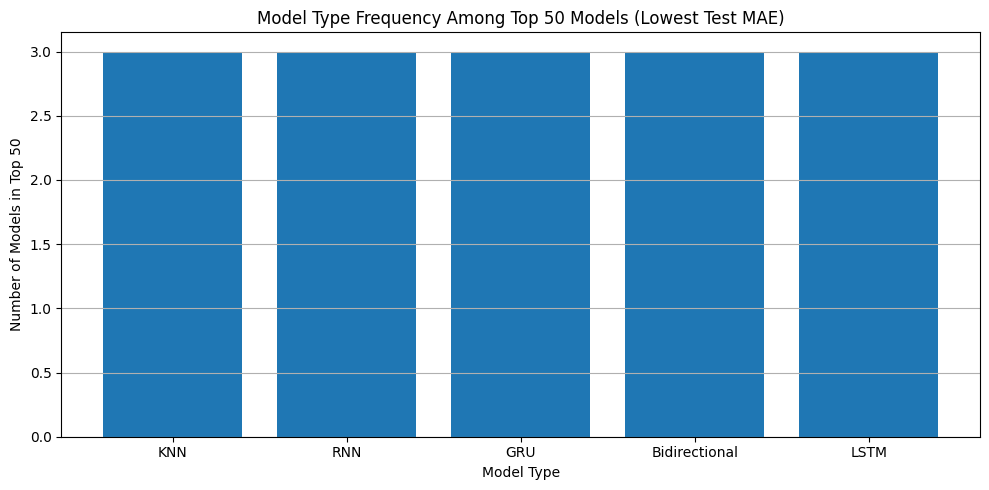

In [33]:
top_50 = results_df.sort_values(by='test_mae', ascending=True).head(50)
model_types = pd.Series([i.split('_')[0] for i in top_50['Model']])
model_counts = model_types.value_counts().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(model_counts.index, model_counts.values)

# Labels and aesthetics
plt.xlabel('Model Type')
plt.ylabel('Number of Models in Top 50')
plt.title('Model Type Frequency Among Top 50 Models (Lowest Test MAE)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [38]:
top_50 = results_df.sort_values('test_mae').head(50)
print(top_50['Model'].value_counts())

Model
KNN_High_90                   1
KNN_High_60                   1
KNN_High_30                   1
RNN_High_30                   1
RNN_High_60                   1
RNN_High_90                   1
GRU_High_30                   1
Bidirectional_LSTM_High_30    1
Bidirectional_LSTM_High_60    1
GRU_High_60                   1
GRU_High_90                   1
LSTM_High_30                  1
Bidirectional_LSTM_High_90    1
LSTM_High_60                  1
LSTM_High_90                  1
Name: count, dtype: int64


### 11. Saving Models

1. **Save Results Table**
   - `results_df.to_csv('models.csv')` → save metrics as CSV  

2. **Save Trained Models**
   - `joblib.dump(trained_models, 'trained_models.joblib')`  
   - Stores all fitted ML + DL models + their metrics  

3. **Load Models**
   - `loaded_models = joblib.load('trained_models.joblib')`  
   - Reload models/metrics into memory for reuse  

In [34]:
import joblib

results_df.to_csv('models.csv')
joblib.dump(trained_models, 'trained_models.joblib')

loaded_models = joblib.load('trained_models.joblib')

### 12. Loading Saved Models

1. **Access Specific Model**
   - `loaded_models['KNN_High_90']`  
   - Retrieves dictionary with:
     - Trained model object  
     - Train/Test MAE & RMSE metrics  

2. **Extract Model**
   - `model = loaded_models['KNN_High_90']['model']`  
   - Assigns the trained KNN regressor to `model` variable  
   - Now can be used for `.predict()` on new data  

In [35]:
loaded_models['KNN_High_90']
model = loaded_models['KNN_High_90']['model']

### 13. Model Inference

1. **Inspect Input Sample**
   - `print(chunked_data['X_Open_90'][5])`  
   - Displays the 6th sample from feature set `X_Open_90`  

2. **Make Prediction**
   - `model.predict([chunked_data['X_Open_90'][5]])`  
   - Wrap sample in a list → ensures 2D shape `(1, n_features)`  
   - Outputs predicted value for that input using trained KNN model  

In [36]:
print(chunked_data['X_Open_90'][5])
print(model.predict([chunked_data['X_Open_90'][5]]))

[1615.65 1633.25 1572.3  1627.85 1622.15 1623.5  1611.65 1610.05 1634.65
 1601.25 1623.05 1612.95 1600.5  1603.65 1598.35 1546.2  1554.2  1591.25
 1598.5  1599.8  1636.6  1666.95 1692.1  1712.85 1777.75 1744.5  1704.85
 1710.05 1742.3  1719.55 1754.2  1745.2  1696.4  1734.05 1711.15 1722.85
 1661.5  1713.65 1696.45 1656.   1711.85 1717.75 1667.45 1647.85 1601.4
 1561.55 1546.8  1620.4  1563.3  1551.05 1590.3  1554.2  1570.45 1563.3
 1569.3  1556.95 1545.55 1528.7  1534.05 1428.5  1436.15 1453.3  1557.55
 1613.   1624.4  1587.95 1518.55 1443.55 1417.75 1405.7  1416.05 1383.8
 1362.5  1436.15 1419.9  1410.   1330.15 1317.95 1381.9  1423.25 1362.45
 1380.4  1359.1  1305.3  1281.3  1300.2  1310.8  1311.3  1293.45 1267.85]
[1261.65]


- High
- KNN,RNN,GRU,LSTM,Bidirectional (50 Epochs)
- 30,60,90

### Assignment

- High
- KNN,RNN,GRU,LSTM,Bidirectional (50 Epochs)
- 30,60,90

### Assignment Documentation

Based on the analysis performed in this notebook, the assignment is to focus on building and evaluating models for predicting the **High** price of the NIFTY 50 index.

Specifically, you should concentrate on the following models and time windows:

*   **Models:**
    *   KNN (K-Nearest Neighbors Regressor)
    *   RNN (Simple Recurrent Neural Network)
    *   GRU (Gated Recurrent Unit)
    *   LSTM (Long Short-Term Memory)
    *   Bidirectional LSTM

*   **Time Windows (Input Days):**
    *   30 days
    *   60 days
    *   90 days

For the Deep Learning models (RNN, GRU, LSTM, Bidirectional LSTM), train them for **50 epochs**.

The goal is to train these specific models for the 'High' column using the specified time windows and evaluate their performance using MAE and RMSE, comparing the results.